# Associations between microbial presence/absence and patient info

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(doParallel)
require(ggrepel)
registerDoParallel(cores = 8)


Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required packag

### Load  data

In [2]:
X <- fread("results/decontamination/prevalence_RA0.005_read10.csv")
nc <- fread("results/decontamination/curated_n124_global_decontamination_stats.csv")
X <- X %>% select(all_of(c("npm_research_id", nc$taxa)))

meta <- fread("data/20210125_v3_release/20210203_all_traits_v3.txt")
meta2 <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv")

n <- gsub("[^0-9A-Za-z///' ]", " ", colnames(meta))
n <- tolower(n)
n <- gsub(" ", "_", n)
colnames(meta) <- n

fwrite(meta, "data/20210125_v3_release/20210203_all_traits_v3.parsed.csv")
X_meta <- X %>%
    left_join(meta, "npm_research_id") %>%
    left_join(meta2, "npm_research_id") %>%
    as_tibble()

head(X_meta)

npm_research_id,Fusobacterium nucleatum,Staphylococcus haemolyticus,Cutibacterium acnes,Staphylococcus cohnii,Human mastadenovirus C,Neisseria subflava,Corynebacterium segmentosum,Haemophilus parainfluenzae,Fannyhessea vaginae,⋯,supplied_and_computed_gender_match,sop_agreement_for_coverage__14/_28_for_15x/30x,sample_life_cycle,current,source_cohort,original_supplier_id,duplicate_info.y,duplicate.y,duplicate_pair.y,removal_requested_by_supplier
<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WHB8690,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,MEC VCF,Y,MEC,17003-2486,Unknown,PASS,Unknown,Unknown
WHB10005,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,N,HELIOS VCF,Y,HELIOS,00363,Unknown,PASS,Unknown,Unknown
WHB4505,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,010-21829,Unknown,PASS,Unknown,Unknown
WHB7030,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,MEC VCF,Y,MEC,17003-0826,Unknown,PASS,Unknown,Unknown
WHB8628,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,MEC VCF,Y,MEC,17003-2424,Unknown,PASS,Unknown,Unknown
WHB4900,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,PRISM VCF,Y,PRISM,0717-0025/NHC/ACP,Unknown,PASS,Unknown,Unknown


In [3]:
taxon_list <- colSums(X[, 2:ncol(X)]) >= 50
taxon_list <- names(taxon_list[taxon_list])
length(taxon_list)
taxon_list

[1] 17

[1] "Staphylococcus haemolyticus"  "Cutibacterium acnes"         
 [3] "Staphylococcus cohnii"        "Human mastadenovirus C"      
 [5] "Staphylococcus epidermidis"   "Lactobacillus crispatus"     
 [7] "Moraxella osloensis"          "Gardnerella vaginalis"       
 [9] "Mycolicibacterium aubagnense" "Lactobacillus iners"         
[11] "Phyllobacterium zundukense"   "Acidovorax sp. KKS102"       
[13] "Bifidobacterium adolescentis" "Paraburkholderia acidiphila" 
[15] "Paraburkholderia sp. 7MH5"    "Paraburkholderia tropica"    
[17] "Paraburkholderia acidisoli"

In [4]:
# Get variable lists
taxon_list <- colSums(X[, 2:ncol(X)]) >= 50
taxon_list <- names(taxon_list[taxon_list])
length(taxon_list)

categorical_list_full <- c("fasting", "genetic_sex", "genetic_ancestry", 
                      "diab_med", "htn_med", "lipid_med", "t2d")
cont_list_full <- c("age", "bmi", 
               "height_cm", "weight_kg", "waistc_cm", "hipc_cm", 
               "tc_mmol_l", "ldl_direct_mmol_l", "hdl_mmol_l", "tg_mmol_l",
               "glu_fast_mmol_l", "ins_fast_uiu_ml", "glu_rand_mmol_l",
               "ldl_cal_mmol_l",              
               "sbp", "dbp")

categorical_list <- c("genetic_sex", "genetic_ancestry")
cont_list <- c("age", "bmi", "tc_mmol_l", "tg_mmol_l", 
               "sbp", "dbp")

[1] 17

In [5]:
cohort_list <- unique(X_meta$site_supplying_sample)
cohort_list <- cohort_list[cohort_list != "SSMP"]
cohort_list

n_comparisons <- length(cohort_list) * length(taxon_list) * (length(categorical_list) + length(cont_list))
n_comparisons

[1] "MEC"    "HELIOS" "GUSTO"  "PRISM"  "SERI"   "TTSH"

[1] 816

### Basic stats on phenotypes

In [6]:
n_df <- X_meta %>%
    select(npm_research_id, site_supplying_sample) %>%
    group_by(site_supplying_sample) %>%
    summarise(cohort_total = n())

plot_list <- foreach (col = categorical_list_full) %do% {
X_meta %>%
        group_by_at(c(col, "site_supplying_sample")) %>%
        summarise(count = n()) %>%
        left_join(n_df) %>%
        mutate(col = factor(get(col), levels = unique(get(col)))) %>%
        ggplot(aes(x = site_supplying_sample, y = count, fill = col)) +
            geom_bar(position = "stack", stat = "identity") +
            theme(legend.position = "top") +
            geom_text(aes(x = site_supplying_sample, y = -3, label = paste0("n = ", cohort_total)),
                      vjust = 0) +
            labs(fill = col)
}

plot_list2 <- foreach (col = cont_list_full) %do% {
    X_meta %>%
        left_join(n_df) %>%
        ggplot(aes_string(x = "site_supplying_sample", y = col, fill = "genetic_sex")) +
            geom_boxplot() +
            theme(legend.position = "top") +
            geom_text(aes(x = site_supplying_sample, y = -3, label = paste0("n = ", cohort_total)),
                      vjust = 0) +
            labs(y = col)
}

plot_list <- c(plot_list, plot_list2)
pdf("results/phenotype_associations/metadata_barcharts2.pdf")
for (plt in plot_list) {
    print(plt)
}
dev.off()

`summarise()` has grouped output by 'fasting'. You can override using the `.groups` argument.
Joining, by = "site_supplying_sample"
`summarise()` has grouped output by 'genetic_sex'. You can override using the `.groups` argument.
Joining, by = "site_supplying_sample"
`summarise()` has grouped output by 'genetic_ancestry'. You can override using the `.groups` argument.
Joining, by = "site_supplying_sample"
`summarise()` has grouped output by 'diab_med'. You can override using the `.groups` argument.
Joining, by = "site_supplying_sample"
`summarise()` has grouped output by 'htn_med'. You can override using the `.groups` argument.
Joining, by = "site_supplying_sample"
`summarise()` has grouped output by 'lipid_med'. You can override using the `.groups` argument.
Joining, by = "site_supplying_sample"
`summarise()` has grouped output by 't2d'. You can override using the `.groups` argument.
Joining, by = "site_supplying_sample"
Joining, by = "site_supplying_sample"
Joining, by = "site_supply

png 
  2

## Phenotype association tests

In [7]:
morsels <- foreach(cohort = cohort_list) %do% {
    cat_morsels <- foreach (category = categorical_list) %dopar% {
        X_meta_filt <- X_meta %>% 
            filter(!is.na(get(category)),
                   site_supplying_sample == cohort)
        var_vec <- deframe(X_meta_filt[, category])

        foreach (taxon = taxon_list) %do% {
            species_vec <- deframe(X_meta_filt[, taxon])

            if(sum(species_vec) > 0 & length(unique(var_vec)) >= 2) {
                test <- fisher.test(var_vec, species_vec)
                return(tibble(taxa = taxon, variable = category, OR = test$estimate, p = test$p.value))
            } else {
                return(tibble(taxa = taxon, variable = category, OR = NA, p = NA))
            }
        }
    }

    cat_res <- bind_rows(cat_morsels)

    # For continuous variables
    cont_morsels <- foreach (cont = cont_list) %dopar% {
        X_meta_filt <- X_meta %>% 
            filter(!is.na(get(cont)),
                   site_supplying_sample == cohort)
        var_vec <- deframe(X_meta_filt[, cont])

        foreach (taxon = taxon_list) %do% {
            species_vec <- deframe(X_meta_filt[, taxon])

            if(sum(species_vec) > 0) {
                test <- wilcox.test(var_vec ~ species_vec, correct = F, alternative = "two.sided") 
                return(tibble(taxa = taxon, variable = cont, 
                              U = test$statistic, 
                              p = test$p.value))
            } else {
                return(tibble(taxa = taxon, variable = cont, 
                                          U = NA, 
                                          p = NA))
            }
        }
    }

    cont_res <- bind_rows(cont_morsels)

    res_temp <- cat_res %>%
        bind_rows(cont_res) %>%
        add_column(cohort = cohort)
    res_temp
}

res <- bind_rows(morsels)

In [8]:
n_not_tested <- res %>%
    filter(is.na(p)) %>%
    nrow()

n_comparisons_final <- n_comparisons - n_not_tested
print(n_comparisons_final)
a <- 0.05

res_filt <- res %>%
    filter(!is.na(p)) %>%
    mutate(p.adj = p.adjust(p, "BH", n = n_comparisons_final)) %>%
    mutate(log_p_adj = -log(p.adj, base = 10),
           annot = ifelse(log_p_adj > 5, taxa, ""),
           variable = case_when(variable == "genetic_ancestry" ~ "Ancestry",
                                variable == "age" ~  "Age",
                                variable == "tg_mmol_l" ~ "Triglycerides",
                                variable == "bmi" ~ "BMI",
                                variable == "tc_mmol_l" ~ "Total cholesterol",
                                variable == "genetic_sex" ~ "Sex",
                                variable == "sbp" ~ "SBP",
                                variable == "dbp" ~ "DBP"),
           color_value = ifelse(p.adj > a, NA, log_p_adj))

[1] 474


In [9]:
n_sig_df <- res_filt %>% 
    filter(p.adj < 0.05) %>%
    group_by(taxa, variable) %>%
    summarise(n_sig = n())

`summarise()` has grouped output by 'taxa'. You can override using the `.groups` argument.


In [10]:
res_filt %>% 
    filter(p.adj < 0.05) %>%
    left_join(n_sig_df) %>%
    group_by(taxa, variable) %>%
    summarise(min_p.adj = min(p.adj), n_sig = min(n_sig))

Joining, by = c("taxa", "variable")
`summarise()` has grouped output by 'taxa'. You can override using the `.groups` argument.


taxa,variable,min_p.adj,n_sig
<chr>,<chr>,<dbl>,<int>
Acidovorax sp. KKS102,Ancestry,2.955357e-02,1
Bifidobacterium adolescentis,Ancestry,1.132874e-05,1
Cutibacterium acnes,Ancestry,2.929320e-07,3
Human mastadenovirus C,Age,7.997147e-06,1
Human mastadenovirus C,Triglycerides,1.637228e-02,1
Moraxella osloensis,Ancestry,2.559229e-04,1
Paraburkholderia acidiphila,Ancestry,9.851253e-24,1
Paraburkholderia acidisoli,Ancestry,4.125765e-22,1
Paraburkholderia sp. 7MH5,Ancestry,8.457708e-26,1


Joining, by = c("taxa", "variable")
`summarise()` has grouped output by 'taxa'. You can override using the `.groups` argument.
Warning message:
“Using size for a discrete variable is not advised.”
Warning message:
“Using size for a discrete variable is not advised.”


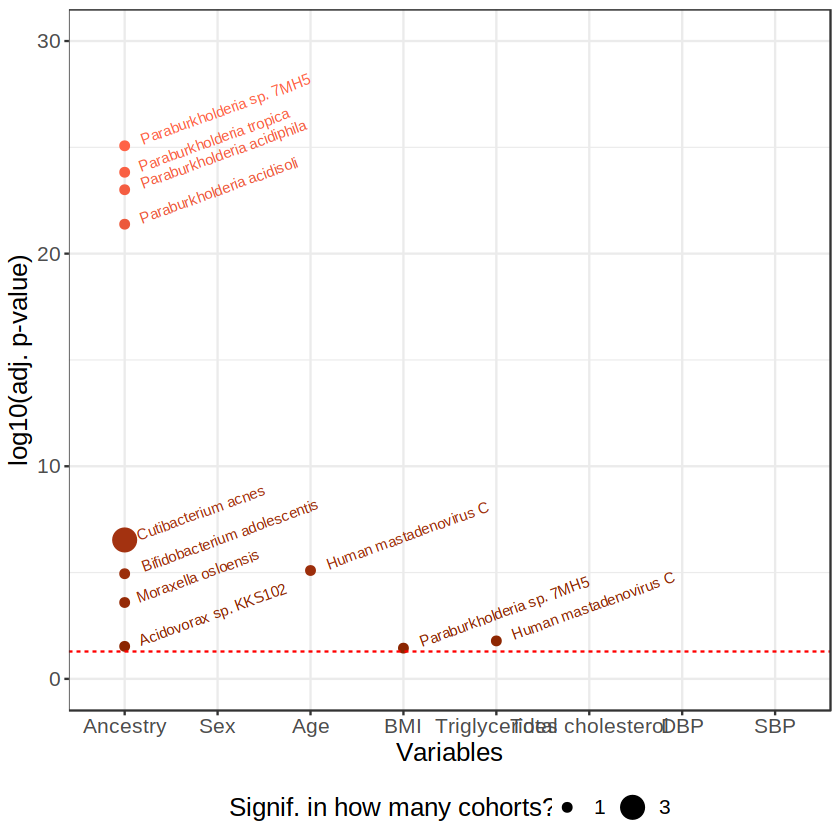

In [11]:
res_filt %>% 
    filter(p.adj < 0.05) %>%
    left_join(n_sig_df) %>%
    group_by(taxa, variable) %>%
    summarise(min_p.adj = min(p.adj), n_sig = min(n_sig)) %>%
    mutate(log_p_adj = -log(min_p.adj, base = 10),
           n_sig = factor(n_sig),
           variable = factor(variable, levels = c("Ancestry", "Sex", "Age", 
                                                  "BMI", "Triglycerides", "Total cholesterol", 
                                                  "DBP", "SBP"))) %>%
    ggplot(aes(x = variable, y = log_p_adj, size = n_sig, color = log_p_adj)) +
        geom_point() +
        geom_hline(yintercept = -log(a, base = 10), 
                   lty = "dashed",
                   color = "red") +
        scale_color_gradient(low = "orangered4", 
                             high = "tomato1", 
                             na.value = "darkgray",
                             guide = "none") + 
        scale_x_discrete(drop = F) +
        theme_bw() +
        theme(text = element_text(size = 15),
              legend.position = "bottom") +
        geom_text(aes(label = taxa), angle = 20, hjust = -0.1, size = 3) +
        labs(x = "Variables", y = "log10(adj. p-value)", size = "Signif. in how many cohorts?") +
        ylim(0, 30)

ggsave("results/phenotype_associations/manhattan_plot.separate.simple.png", dpi = 600, width = 11, height = 4)

### Plot prevalence for C. acnes

`summarise()` has grouped output by 'genetic_ancestry'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'genetic_ancestry'. You can override using the `.groups` argument.
Joining, by = c("genetic_ancestry", "site_supplying_sample")


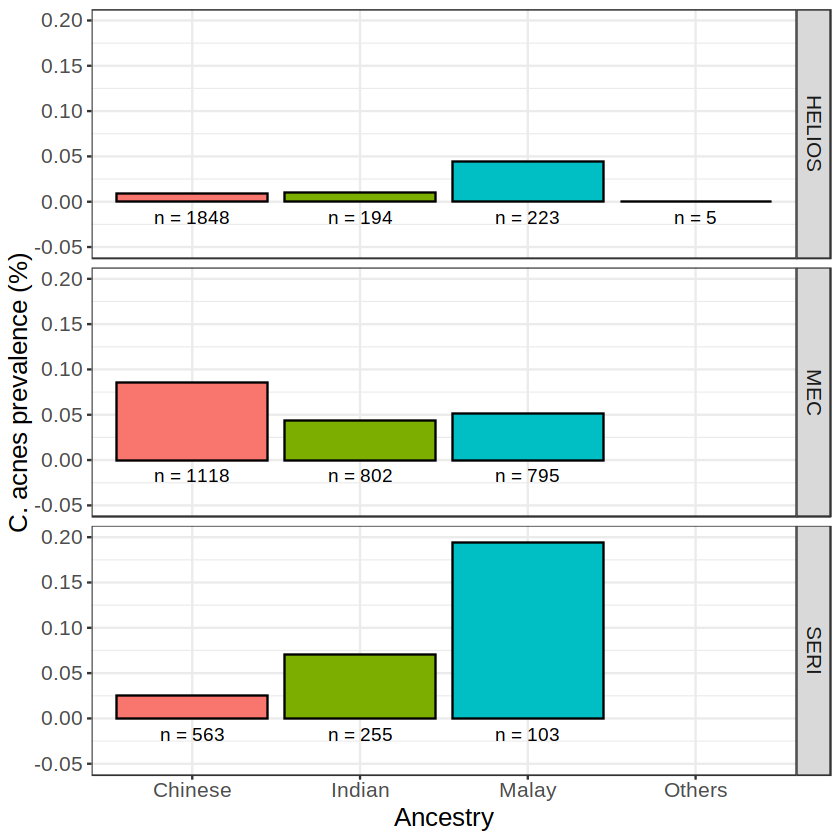

In [12]:
taxon <- "Cutibacterium acnes"    
n_df <- X_meta %>%
    group_by(genetic_ancestry, site_supplying_sample) %>%
    summarise(n_total = n())

cohorts_of_interest <- res_filt %>% 
    filter(taxa == taxon,
           p.adj < 0.05)
cohorts_of_interest <- unique(cohorts_of_interest$cohort)

X_meta %>%
    filter(site_supplying_sample %in% cohorts_of_interest) %>%
    filter(!is.na(genetic_ancestry)) %>%
    select(all_of(c(taxon, "genetic_ancestry", "site_supplying_sample"))) %>%
    pivot_longer(!c(genetic_ancestry, site_supplying_sample), names_to = "site", values_to = "presence") %>%
    group_by(genetic_ancestry, site_supplying_sample) %>%
    summarise(n = sum(presence)) %>%
    left_join(n_df) %>%
    mutate(prop = n / n_total,
           genetic_ancestry = case_when(genetic_ancestry == "C" ~ "Chinese",
                                        genetic_ancestry == "M" ~ "Malay",
                                        genetic_ancestry == "I" ~ "Indian",
                                        genetic_ancestry == "O" ~ "Others")) %>%
    ggplot(aes(x = genetic_ancestry, y = prop, fill = genetic_ancestry)) +
        facet_grid(rows = vars(site_supplying_sample)) +
        geom_bar(stat = "identity", 
                 position = "dodge",
                 color = "black") +
        labs(x = "Ancestry", y = "C. acnes prevalence (%)") +
#         geom_text(aes(y = prop, label = n),
#                   vjust = 0,
#                   color = "red") +
        geom_text(aes(y = -0.01, label = paste0("n = ", n_total)),
                  vjust = 1,
                  color = "black") +
        theme_bw() +
        theme(legend.position = "none",
              text = element_text(size = 15)) +
        ylim(-0.05, 0.2)

taxon_save_name <- paste0(taxon, collapse = "_")
ggsave(str_glue("results/phenotype_associations/separate_simple_plots/{taxon_save_name}.genetic_ancestry.png"), 
       width = 6, height = 7)

### Iterate across all significant hits

In [13]:
sig_list <- (res_filt %>%
    filter(p.adj < 0.05) %>%
    distinct(taxa))$taxa
for (taxon in sig_list) {
    X_meta %>%
            select(all_of(c(taxon, "genetic_ancestry", "site_supplying_sample"))) %>%
            pivot_longer(!c(genetic_ancestry, site_supplying_sample), names_to = "site", values_to = "presence") %>%
            group_by(genetic_ancestry, site_supplying_sample) %>%
            summarise(n = sum(presence)) %>%
            left_join(n_df2) %>%
            mutate(prop = n / n_total) %>%
            ggplot(aes(x = genetic_ancestry, y = prop, fill = genetic_ancestry)) +
                facet_grid(rows = vars(site_supplying_sample)) +
                geom_bar(stat = "identity", position = "dodge") +
                labs(x = "genetic_ancestry", y = "Prop. of positive samples") +
                geom_text(aes(y = prop, label = n),
                          vjust = 0,
                          color = "red") +
                geom_text(aes(y = -0.01, label = paste0("n_sampled = ", n_total)),
                          vjust = 1,
                          color = "black") +
    ylim(-0.1, 0.6)
        taxon_save_name <- paste0(taxon, collapse = "_")
        ggsave(str_glue("results/phenotype_associations/separate_simple_plots/{taxon_save_name}.genetic_ancestry.png"), 
               width = 15, height = 7)
}

`summarise()` has grouped output by 'genetic_ancestry'. You can override using the `.groups` argument.


ERROR: Error in is.data.frame(y): object 'n_df2' not found
